In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import os
import librosa


In [2]:
noise_file = "/Users/aaryansinghrajput/Developer/audio-visualizer/data/noisy/chattering-in-a-restaurant-6718.wav"
no_noise_file =  "/Users/aaryansinghrajput/Developer/audio-visualizer/data/no_noise/silent_wav_2.wav"
print(noise_file)

/Users/aaryansinghrajput/Developer/audio-visualizer/data/noisy/chattering-in-a-restaurant-6718.wav


In [3]:
def load_wav_16k_mono(filename):

    file_contents = tf.io.read_file(filename)
    # Decoding the audio file into raw bytes
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removing files that have less than 44100 samples
    # Resample Audio using Librosa
    audio_resampled = librosa.resample(wav.numpy().flatten(), orig_sr=sample_rate.numpy(), target_sr=16000)
    # Converting the Resampled Audio Shape to Tensor
    audio_tensor_resampled = tf.convert_to_tensor(audio_resampled, dtype=tf.float32)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    return audio_tensor_resampled

#### Removing files less than 44100 hz because we are resampling them

In [4]:
remove_files = []
for files in os.listdir(os.path.join('data', 'noisy')): 
    if(files != '.DS_Store'): 
        wav = load_wav_16k_mono(os.path.join('data', 'noisy', files))
        if wav == None:
            remove_files.append(os.path.join('data', 'noisy', files))

In [5]:
noise_wav_data = load_wav_16k_mono(noise_file)
no_noise_wav_data = load_wav_16k_mono(no_noise_file)

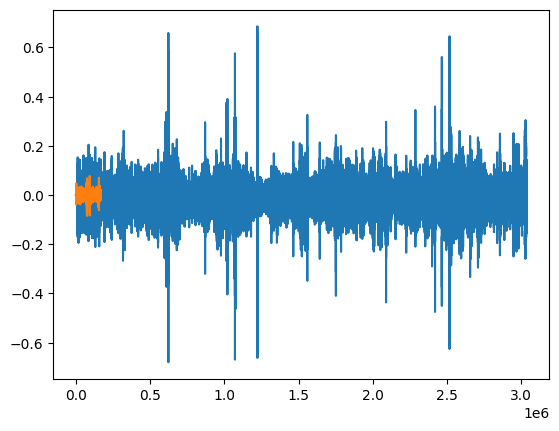

In [6]:
plt.plot(noise_wav_data)
plt.plot(no_noise_wav_data)
plt.show()

# Creating Dataset

In [7]:
POS = "/Users/aaryansinghrajput/Developer/audio-visualizer/data/noisy"
NEG = "/Users/aaryansinghrajput/Developer/audio-visualizer/data/no_noise"

In [8]:
pos = tf.data.Dataset.list_files(POS + "/*.wav")
neg = tf.data.Dataset.list_files(NEG + "/*.wav")

#### Add labels and combine positive and negative to create complete dataset

In [35]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)


## Determine Average Length of Noisy Values

In [10]:
lengths = []
for file in os.listdir(os.path.join('data', 'noisy')):
    if(file == '.DS_Store'): 
        continue
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'noisy',file))
    lengths.append(len(tensor_wave))

In [11]:
print(lengths)

[189280, 158880, 281504, 1103617, 153440, 2198400, 66560, 761396, 583472, 3037056, 158880, 158880, 1101697, 158880, 761396, 158880, 153396, 190900, 158880, 233389, 153440, 158880, 158880, 153440, 158880, 158880, 233389, 153440, 233389, 66560, 153396, 158880, 153440, 189280, 583472, 1101697, 281504, 158880, 158880, 3037056, 153440, 190900, 400959, 1103617, 217920, 2198400, 400959, 158880, 158880, 158880, 233389, 217920]


In [12]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=66560>

In [13]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=3037056>

In [14]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=480165>

Building Preprocessing Function


In [15]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [16]:
filepath, label = negatives.shuffle(buffer_size=1000).as_numpy_iterator().next()
filepath

b'/Users/aaryansinghrajput/Developer/audio-visualizer/data/no_noise/copy_4_silent_wav_2.wav'

In [17]:
spectrogram, label = preprocess(filepath, label)

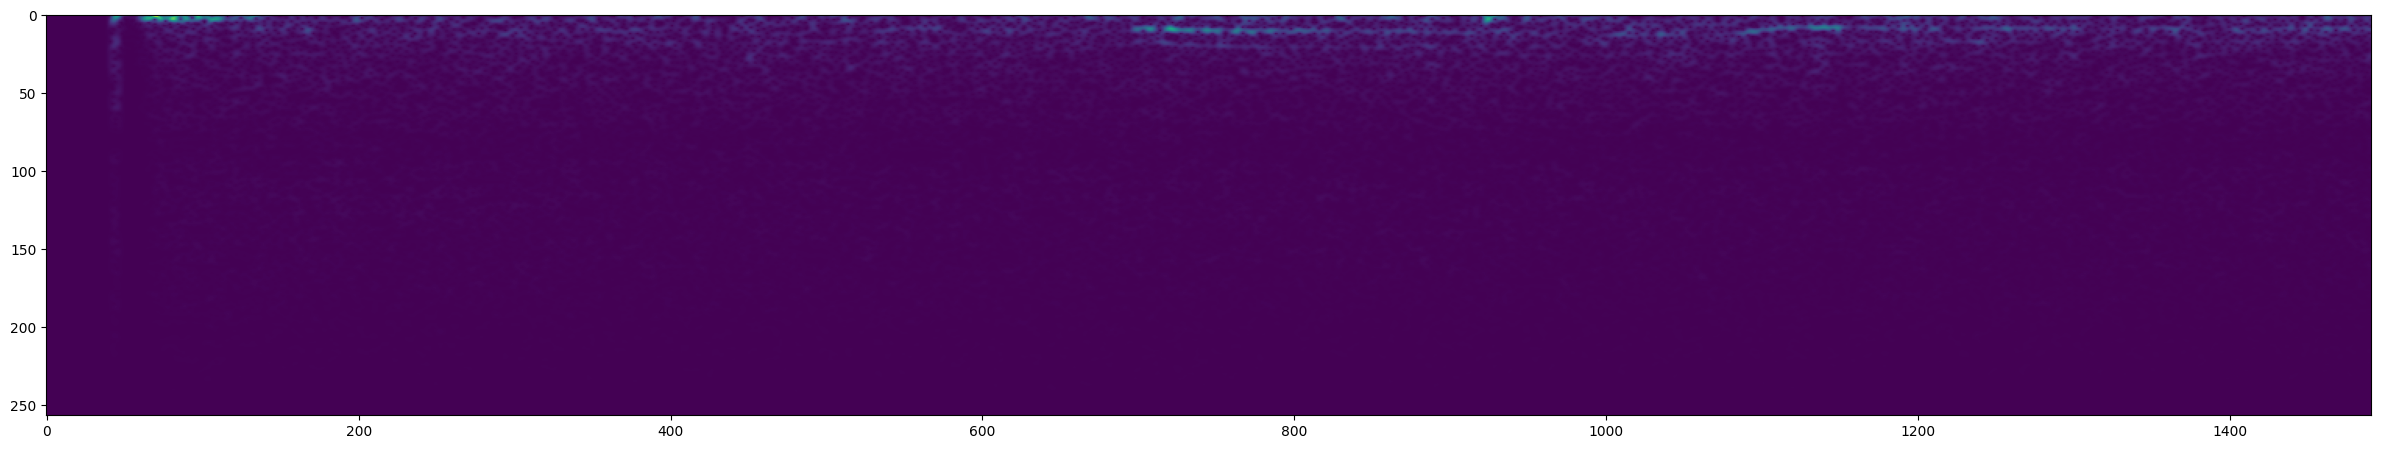

In [18]:
# plt.figure(figsize=(30, 20))
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [19]:
def set_shape(feature, labels):
    feature.set_shape([1491, 257, 1])
    labels.set_shape([16])
    return feature, labels

In [36]:
data = data.map(lambda filepath, labels: tf.py_function(preprocess,
                                                        inp=[filepath, labels],
                                                        Tout=[tf.float32, tf.float32]))
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [38]:
samples, labels = data.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [23]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


/Users/aaryansinghrajput/Developer/audio-visualizer/env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])